#Вспомогательные функции и классы

##Датасет

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def make_dataset(num_elements = 50):
    #Пока не будем менять константы, если будет нужно, модернизируем функцию
    a = 20
    b = 3 
    c = 4

    x0 = 1
    y0 = 2
    z0 = 3

    norm = np.array([a, b, c])
    point = np.array([x0, y0, z0])
    #Получим d
    d = -point.dot(norm)
    #Построим точки для плоскости

    left_border_plane = -100
    right_border_plane = 100

    x = np.linspace(left_border_plane, right_border_plane, num_elements)
    y = np.linspace(left_border_plane, right_border_plane, num_elements)

    X, Y = np.meshgrid(x, y)

    Z = (-a * X - b * Y - d) * 1. / c

    #Растянем наши матрицы в одномерный массив
    x_data = X.ravel()
    y_data = Y.ravel()
    z_data = Z.ravel()

    n = num_elements * num_elements
    #Добавим шума
    x_data = x_data + 5 * np.random.randn(n)
    y_data = y_data + 5 * np.random.randn(n)
    z_data = z_data + np.random.randn(n)

    #Составим матрицу признаков
    data = pd.DataFrame({'x' : x_data, 'y' : y_data, 'z' : z_data})
    #Перемешаем данные (можно этого и не делать, потому что далее train_test_split все перемешает, но на всякий случаем сделаем)
    data = data.sample(frac = 1)
    #Разделим выборку на признаки и таргет
    Fich = data.iloc[ : , : -1]
    target = data['z']
    return Fich, target, left_border_plane, right_border_plane

## Класс аналитического решения

In [2]:
class MyLinearRegression:
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept

    def fit(self, X, y):
        n, k = X.shape
        X_ = X
        #Не забудем про фиктивный признак равный 1
        if self.fit_intercept:
            X_ = np.hstack((X, np.ones((n, 1))))
        #self.w = np.linalg.inv(X_.T @ X_) @ X_.T @ y
        self.w, _, self.rank_, self.singular_ = np.linalg.lstsq(X_, y)
        self.w = np.ravel(self.w)
        return self
        
    def predict(self, X):
        n, k = X.shape
        #Не забудем про фиктивный признак равный 1
        X_ = X
        if self.fit_intercept:
            X_ = np.hstack((X, np.ones((n, 1))))

        y_pred = X_ @ self.w

        return y_pred
    #функция возвращающая веса
    def get_weights(self):
        return self.w
        

## Класс градиентного спуска

In [3]:
class MyGradientLinearRegression:
    def __init__(self, fit_intercept = True):
        self.w = None
        self.fit_intercept = fit_intercept

    def fit(self, X, y, lr=0.01, max_iter=10000):
      n_samples, k = X.shape

      if self.w is None:
        self.w = np.zeros(k + 1 if self.fit_intercept else k)
        
      X_ = np.hstack((X, np.ones((n_samples, 1)))) if self.fit_intercept else X

      for epoch in range(max_iter):
        y_pred = self.predict(X)
        dloss = y_pred - y
        
        grad = (2.0 / n_samples) * X_.T.dot(dloss)
        self.w -= lr * grad

      return self
        
    def predict(self, X):
          # Принимает на вход X и возвращает ответы модели
          # Не забудем про фиктивный признак равный 1
          n, k = X.shape
          X_ = X.copy()
          if self.fit_intercept:
              X_ = np.hstack((X, np.ones((n, 1))))

          y_pred = np.matmul(X_, self.w)
          return y_pred
      
    def get_weights(self):
        return self.w

## Класс стохастического градиентного спуска

In [4]:
class MySGDLinearRegression:
    def __init__(self, fit_intercept = True):
        self.fit_intercept = fit_intercept
        self.w = None

    def fit(self, X, y, lr=0.01, max_iter=5000):
        n_samples, k = X.shape

        # Инициируем веса нулями
        if self.w is None:
            self.w = np.zeros(k + 1 if self.fit_intercept else k)
        
        #добавим столбец из единиц для смещения
        X_ = np.hstack((X, np.ones((n_samples, 1)))) if self.fit_intercept else X
        
        for epoch in range(max_iter):
            for i in range(n_samples):
                p = np.matmul(X_[i], self.w)
                dloss = 2 * (p - y[i])
                self.w -= lr * dloss * X_[i]
        return self
    def predict(self, X):
      # Принимает на вход X и возвращает ответы модели
      # Не забудем про фиктивный признак равный 1
      n, k = X.shape
      X_ = X.copy()
      if self.fit_intercept:
          X_ = np.hstack((X, np.ones((n, 1))))

      y_pred = np.matmul(X_, self.w)
      return y_pred
      
    def get_weights(self):
        return self.w

## Вспомогательная функция

In [5]:
#Немного модифицируем нашу функцию. Теперь она также будет возвращать веса в нужном режиме работы (mode)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

def MSE_and_weights(Fich_original, target_original, iters = None, step = 1, rand_size = 1, lr = 0.01, max_iter = 1000, ret = 0, regressor_type = 0, left_border = 0, right_border = 1000):  
  '''
  ret:
  (0) MSE and weights returned
  (1) only MSE returned
  (2) only weights returned
  '''
  
  '''
  regressor_type:
  (0) analitic
  (1) gradient descent
  (2) stochastic gradient descent
  '''

  Fich_copy = Fich_original.copy()
  target = target_original.copy()

  n, _ = Fich_copy.shape

  weights = []
  inter = []
  MSE_train = []
  MSE_test = []
  num_iter = []

  if iters == None:
    iters = []
    for i in range(left_border, right_border, step):
      iters.append([i, step])

  if left_border > 0:
    new_elem = rand_size * np.random.randn(n, left_border)
    names = [str(i) for i in range(left_border)]
    df = pd.DataFrame(new_elem, columns=names, index=range(n))
    Fich = pd.concat([Fich, df], axis=1)
  
  first_first = True
  first = False
  for i, step in tqdm(iters):
      if first:
        #Генерируем новые столбцы
        new_elem = rand_size * np.random.randn(n, step)
        names = [str(k) for k in range(i, i + step)]
        df = pd.DataFrame(new_elem, columns=names, index=range(n))
        Fich = pd.concat([Fich, df], axis=1)
      else:
        if first_first:
          Fich = pd.DataFrame(Fich_copy['x'])
          first_first = False
        else:
          Fich = Fich_copy
          first = True
      #Начинаем обучение
      X_train, X_test, target_train, target_test = train_test_split(Fich.to_numpy(), target.to_numpy(), test_size=0.3)
      #type of regressor
      if regressor_type == 0:
          regressor = MyLinearRegression()
      elif regressor_type == 1:
          regressor = MyGradientLinearRegression()
      else:
          regressor = MySGDLinearRegression()
      
      #fit
      if regressor_type == 0:
          regressor.fit(X_train, target_train)
      else:
          regressor.fit(X_train, target_train, lr = lr, max_iter = max_iter)
      
      train_predictions = regressor.predict(X_train)
      test_predictions = regressor.predict(X_test)
      
      MSE_train.append(mean_squared_error(target_train, train_predictions))
      MSE_test.append(mean_squared_error(target_test, test_predictions))
      tmp = regressor.get_weights()
      weights.append(tmp[:-1])
      inter.append(tmp[-1])
      num_iter.append(X_train.shape[1])
  if ret == 0:
    return MSE_train, MSE_test, weights, inter, num_iter
  elif ret == 1:
    return MSE_train, MSE_test, num_iter
  else:
    return weights, inter, num_iter

In [6]:
import numpy as np
import pandas as pd
def make_range(arr):
  '''arr:
  array of [left, right, step]
  '''
  ans = []
  for new in arr:
    for i in range(new[0], new[1] - new[2], new[2]):
      ans.append([i, new[2]])
  return ans

#Исследование

In [7]:
#Объявим нужные переменные

import warnings
warnings.filterwarnings("ignore")

num_elements = 20
Fich, target, left_border_plane, right_border_plane = make_dataset(num_elements)
rand_size = (right_border_plane - left_border_plane) // 2

n = round(num_elements * num_elements * 0.7)
iters = [[0, 1000, 10]]
iters = make_range(iters)

In [8]:
#analitic
MSE_train, MSE_test, weights, inter, num_iter = MSE_and_weights(Fich, target, rand_size = rand_size, iters=iters, regressor_type = 0)
#Найдем норму
norm_analitic = []
for w in weights:
  norm_analitic.append(np.linalg.norm(w))

answers_analitic = [MSE_train, MSE_test, weights, inter, num_iter]

  0%|          | 0/99 [00:00<?, ?it/s]

In [10]:
#GD lr = 1e-5
MSE_train, MSE_test, weights, inter, num_iter = MSE_and_weights(Fich, target, rand_size = rand_size, iters=iters, regressor_type = 1, max_iter=10000, lr=1e-5)
#Найдем норму
norm_GD5 = []
for w in weights:
  norm_GD5.append(np.linalg.norm(w))

answers_GD5 = [MSE_train, MSE_test, weights, inter, num_iter]

  0%|          | 0/99 [00:00<?, ?it/s]

In [11]:
#GD lr = 1e-6
MSE_train, MSE_test, weights, inter, num_iter = MSE_and_weights(Fich, target, rand_size = rand_size, iters=iters, regressor_type = 1, max_iter=10000, lr=1e-6)
#Найдем норму
norm_GD6 = []
for w in weights:
  norm_GD6.append(np.linalg.norm(w))

answers_GD6 = [MSE_train, MSE_test, weights, inter, num_iter]

  0%|          | 0/99 [00:00<?, ?it/s]

In [12]:
#GD lr = 1e-6
MSE_train, MSE_test, weights, inter, num_iter = MSE_and_weights(Fich, target, rand_size = rand_size, iters=iters, regressor_type = 1, max_iter=10000, lr=1e-7)
#Найдем норму
norm_GD7 = []
for w in weights:
  norm_GD7.append(np.linalg.norm(w))

answers_GD7 = [MSE_train, MSE_test, weights, inter, num_iter]

  0%|          | 0/99 [00:00<?, ?it/s]

In [13]:
#SGD lr = 1e-7
MSE_train, MSE_test, weights, inter, num_iter = MSE_and_weights(Fich, target, rand_size = rand_size, iters=iters, regressor_type = 2, max_iter=10000, lr=1e-7)
#Найдем норму
norm_SGD7 = []
for w in weights:
  norm_SGD7.append(np.linalg.norm(w))

answers_SGD7 = [MSE_train, MSE_test, weights, inter, num_iter]

  0%|          | 0/99 [00:00<?, ?it/s]

In [14]:
#SGD lr = 1e-8
MSE_train, MSE_test, weights, inter, num_iter = MSE_and_weights(Fich, target, rand_size = rand_size, iters=iters, regressor_type = 2, max_iter=10000, lr=1e-8)
#Найдем норму
norm_SGD8 = []
for w in weights:
  norm_SGD8.append(np.linalg.norm(w))

answers_SGD8 = [MSE_train, MSE_test, weights, inter, num_iter]

  0%|          | 0/99 [00:00<?, ?it/s]

In [15]:
#SGD lr = 1e-9
MSE_train, MSE_test, weights, inter, num_iter = MSE_and_weights(Fich, target, rand_size = rand_size, iters=iters, regressor_type = 2, max_iter=10000, lr=1e-9)
#Найдем норму
norm_SGD9 = []
for w in weights:
  norm_SGD9.append(np.linalg.norm(w))

answers_SGD9 = [MSE_train, MSE_test, weights, inter, num_iter]

  0%|          | 0/99 [00:00<?, ?it/s]

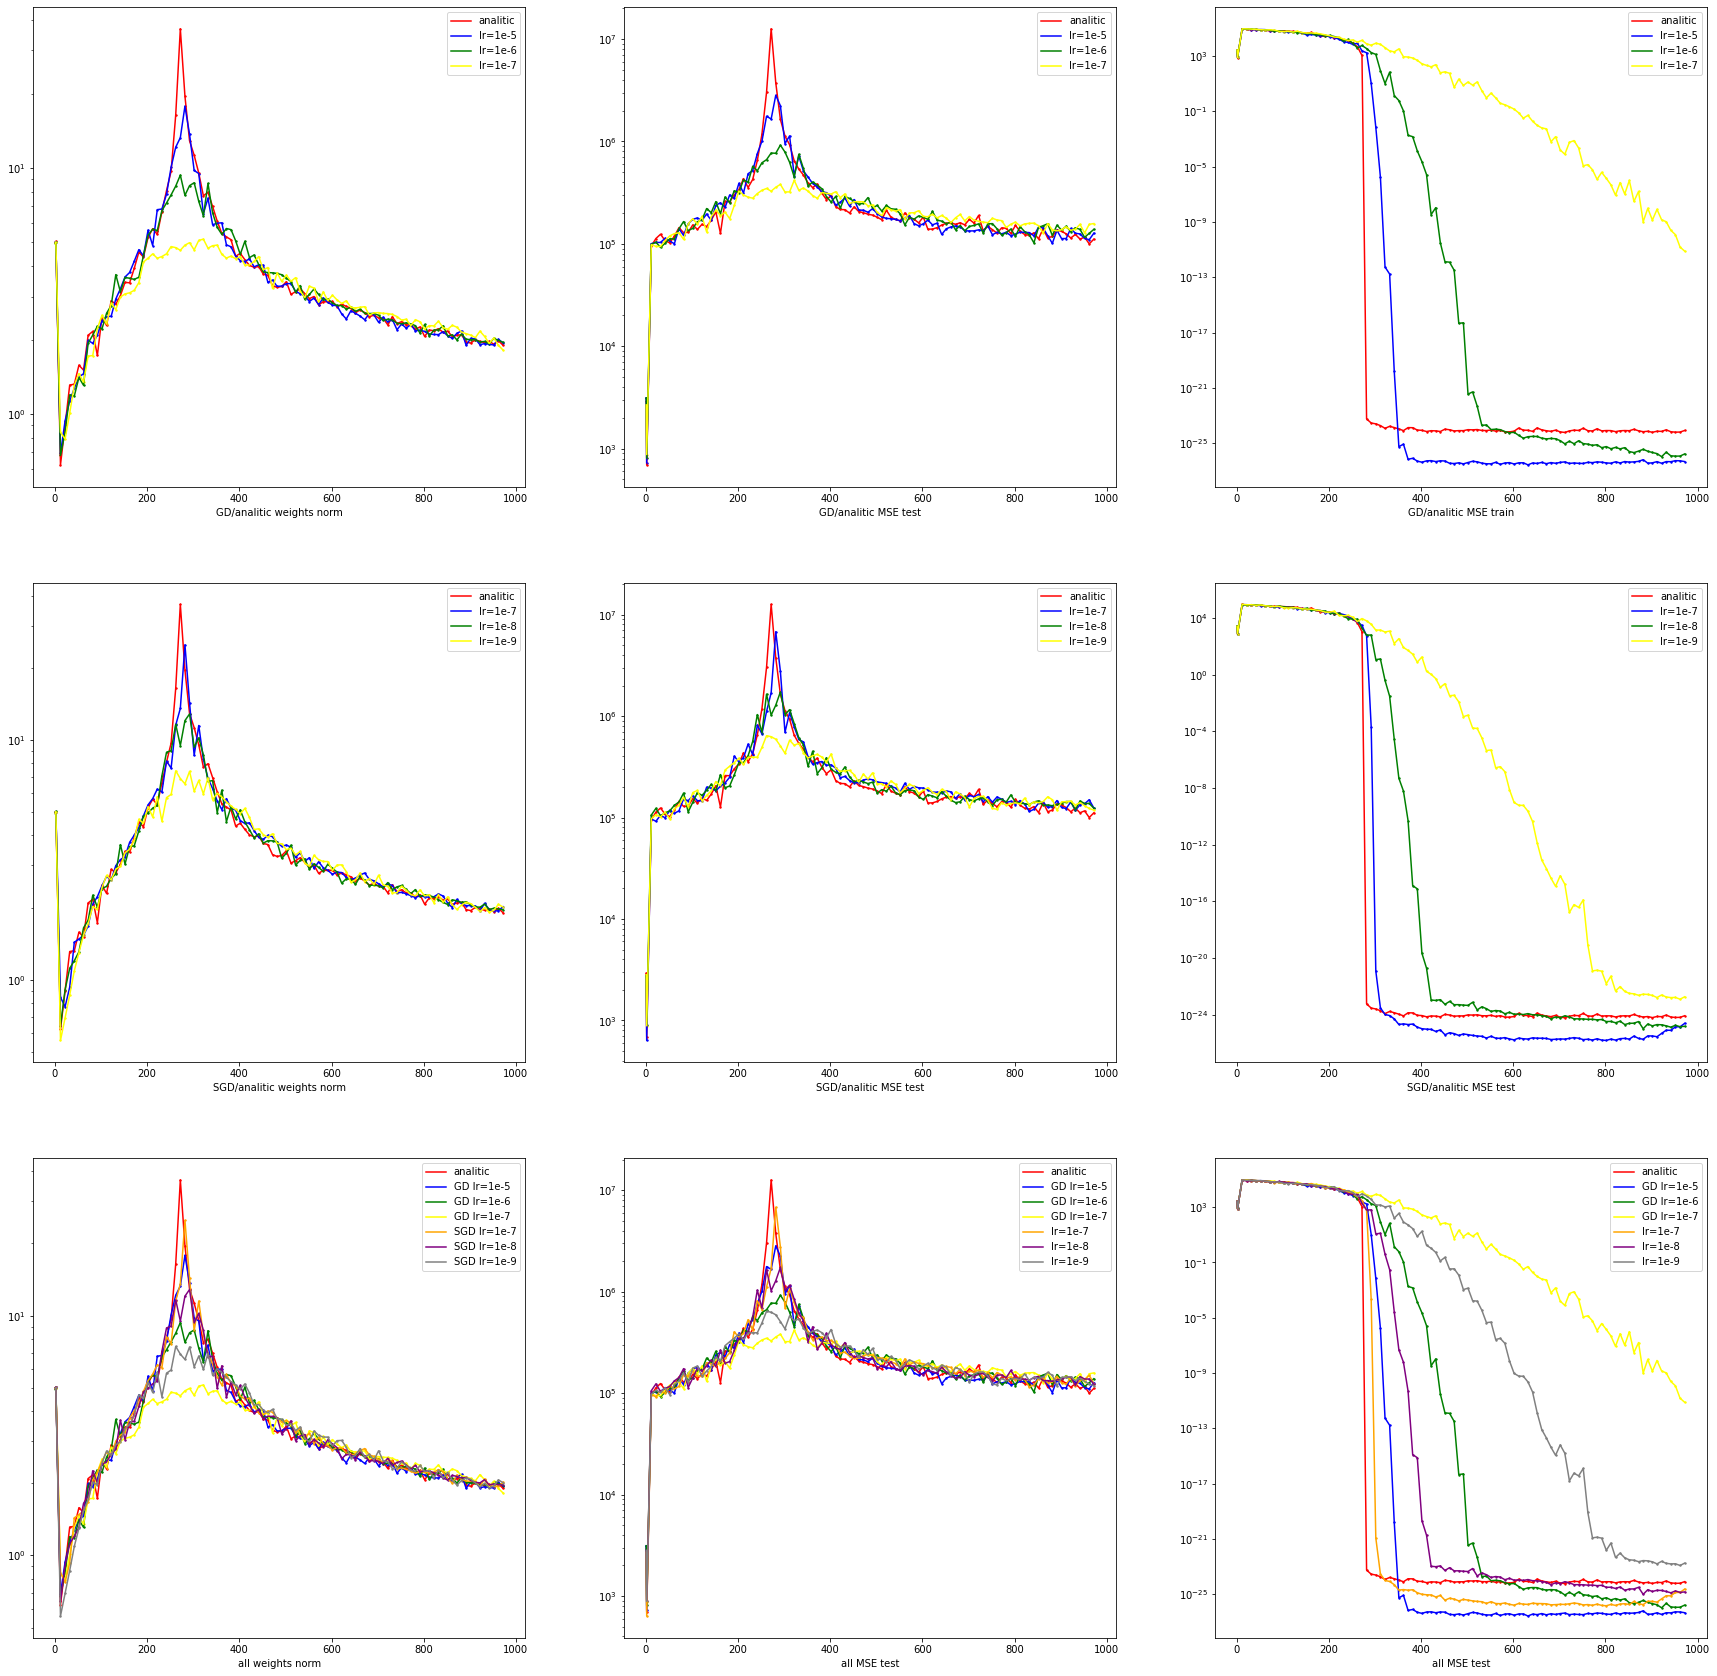

In [16]:
#Нарисуем график
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(30, 30))
ax[0][0].scatter(answers_analitic[4], norm_analitic, color='red', s = 2)
ax[0][0].plot(answers_analitic[4], norm_analitic, color='red', label='analitic')
ax[0][0].scatter(answers_GD5[4], norm_GD5, color='blue', s = 2)
ax[0][0].plot(answers_GD5[4], norm_GD5, color='blue', label='lr=1e-5')
ax[0][0].scatter(answers_GD6[4], norm_GD6, color='green', s = 2)
ax[0][0].plot(answers_GD6[4], norm_GD6, color='green', label='lr=1e-6')
ax[0][0].scatter(answers_GD7[4], norm_GD7, color='yellow', s = 2)
ax[0][0].plot(answers_GD7[4], norm_GD7, color='yellow', label='lr=1e-7')
ax[0][0].set(xlabel = 'GD/analitic weights norm')
ax[0][0].set_yscale('log')
ax[0][0].legend()


ax[0][1].scatter(answers_analitic[4], answers_analitic[1], color = 'red', s = 2)
ax[0][1].plot(answers_analitic[4], answers_analitic[1], color = 'red', label='analitic')
ax[0][1].scatter(answers_GD5[4], answers_GD5[1], color = 'blue', s = 2)
ax[0][1].plot(answers_GD5[4], answers_GD5[1], color = 'blue', label='lr=1e-5')
ax[0][1].scatter(answers_GD6[4], answers_GD6[1], color='green', s = 2)
ax[0][1].plot(answers_GD6[4], answers_GD6[1], color='green', label='lr=1e-6')
ax[0][1].scatter(answers_GD7[4], answers_GD7[1], color='yellow', s = 2)
ax[0][1].plot(answers_GD7[4], answers_GD7[1], color='yellow', label='lr=1e-7')
ax[0][1].set(xlabel = 'GD/analitic MSE test')
ax[0][1].legend()
ax[0][1].set_yscale('log')

ax[0][2].scatter(answers_analitic[4], answers_analitic[0], color = 'red', s = 2)
ax[0][2].plot(answers_analitic[4], answers_analitic[0], color = 'red', label='analitic')
ax[0][2].scatter(answers_GD5[4], answers_GD5[0], color = 'blue', s = 2)
ax[0][2].plot(answers_GD5[4], answers_GD5[0], color = 'blue', label='lr=1e-5')
ax[0][2].scatter(answers_GD6[4], answers_GD6[0], color='green', s = 2)
ax[0][2].plot(answers_GD6[4], answers_GD6[0], color='green', label='lr=1e-6')
ax[0][2].scatter(answers_GD7[4], answers_GD7[0], color='yellow', s = 2)
ax[0][2].plot(answers_GD7[4], answers_GD7[0], color='yellow', label='lr=1e-7')
ax[0][2].set(xlabel = 'GD/analitic MSE train')
ax[0][2].legend()
ax[0][2].set_yscale('log')


ax[1][0].scatter(answers_analitic[4], norm_analitic, color='red', s = 2)
ax[1][0].plot(answers_analitic[4], norm_analitic, color='red', label='analitic')
ax[1][0].scatter(answers_SGD7[4], norm_SGD7, color='blue', s = 2)
ax[1][0].plot(answers_SGD7[4], norm_SGD7, color='blue', label='lr=1e-7')
ax[1][0].scatter(answers_SGD8[4], norm_SGD8, color='green', s = 2)
ax[1][0].plot(answers_SGD8[4], norm_SGD8, color='green', label='lr=1e-8')
ax[1][0].scatter(answers_SGD9[4], norm_SGD9, color='yellow', s = 2)
ax[1][0].plot(answers_SGD9[4], norm_SGD9, color='yellow', label='lr=1e-9')
ax[1][0].set(xlabel = 'SGD/analitic weights norm')
ax[1][0].set_yscale('log')
ax[1][0].legend()


ax[1][1].scatter(answers_analitic[4], answers_analitic[1], color = 'red', s = 2)
ax[1][1].plot(answers_analitic[4], answers_analitic[1], color = 'red', label='analitic')
ax[1][1].scatter(answers_SGD7[4], answers_SGD7[1], color = 'blue', s = 2)
ax[1][1].plot(answers_SGD7[4], answers_SGD7[1], color = 'blue', label='lr=1e-7')
ax[1][1].scatter(answers_SGD8[4], answers_SGD8[1], color='green', s = 2)
ax[1][1].plot(answers_SGD8[4], answers_SGD8[1], color='green', label='lr=1e-8')
ax[1][1].scatter(answers_SGD9[4], answers_SGD9[1], color='yellow', s = 2)
ax[1][1].plot(answers_SGD9[4], answers_SGD9[1], color='yellow', label='lr=1e-9')
ax[1][1].set(xlabel = 'SGD/analitic MSE test')
ax[1][1].legend()
ax[1][1].set_yscale('log')


ax[1][2].scatter(answers_analitic[4], answers_analitic[0], color = 'red', s = 2)
ax[1][2].plot(answers_analitic[4], answers_analitic[0], color = 'red', label='analitic')
ax[1][2].scatter(answers_SGD7[4], answers_SGD7[0], color = 'blue', s = 2)
ax[1][2].plot(answers_SGD7[4], answers_SGD7[0], color = 'blue', label='lr=1e-7')
ax[1][2].scatter(answers_SGD8[4], answers_SGD8[0], color='green', s = 2)
ax[1][2].plot(answers_SGD8[4], answers_SGD8[0], color='green', label='lr=1e-8')
ax[1][2].scatter(answers_SGD9[4], answers_SGD9[0], color='yellow', s = 2)
ax[1][2].plot(answers_SGD9[4], answers_SGD9[0], color='yellow', label='lr=1e-9')
ax[1][2].set(xlabel = 'SGD/analitic MSE test')
ax[1][2].legend()
ax[1][2].set_yscale('log')




ax[2][0].scatter(answers_analitic[4], norm_analitic, color='red', s = 2)
ax[2][0].plot(answers_analitic[4], norm_analitic, color='red', label='analitic')

ax[2][0].scatter(answers_GD5[4], norm_GD5, color='blue', s = 2)
ax[2][0].plot(answers_GD5[4], norm_GD5, color='blue', label='GD lr=1e-5')
ax[2][0].scatter(answers_GD6[4], norm_GD6, color='green', s = 2)
ax[2][0].plot(answers_GD6[4], norm_GD6, color='green', label='GD lr=1e-6')
ax[2][0].scatter(answers_GD7[4], norm_GD7, color='yellow', s = 2)
ax[2][0].plot(answers_GD7[4], norm_GD7, color='yellow', label='GD lr=1e-7')

ax[2][0].scatter(answers_SGD7[4], norm_SGD7, color='orange', s = 2)
ax[2][0].plot(answers_SGD7[4], norm_SGD7, color='orange', label='SGD lr=1e-7')
ax[2][0].scatter(answers_SGD8[4], norm_SGD8, color='purple', s = 2)
ax[2][0].plot(answers_SGD8[4], norm_SGD8, color='purple', label='SGD lr=1e-8')
ax[2][0].scatter(answers_SGD9[4], norm_SGD9, color='gray', s = 2)
ax[2][0].plot(answers_SGD9[4], norm_SGD9, color='gray', label='SGD lr=1e-9')

ax[2][0].set(xlabel = 'all weights norm')
ax[2][0].set_yscale('log')
ax[2][0].legend()





ax[2][1].scatter(answers_analitic[4], answers_analitic[1], color = 'red', s = 2)
ax[2][1].plot(answers_analitic[4], answers_analitic[1], color = 'red', label='analitic')

ax[2][1].scatter(answers_GD5[4], answers_GD5[1], color = 'blue', s = 2)
ax[2][1].plot(answers_GD5[4], answers_GD5[1], color = 'blue', label='GD lr=1e-5')
ax[2][1].scatter(answers_GD6[4], answers_GD6[1], color='green', s = 2)
ax[2][1].plot(answers_GD6[4], answers_GD6[1], color='green', label='GD lr=1e-6')
ax[2][1].scatter(answers_GD7[4], answers_GD7[1], color='yellow', s = 2)
ax[2][1].plot(answers_GD7[4], answers_GD7[1], color='yellow', label='GD lr=1e-7')

ax[2][1].scatter(answers_SGD7[4], answers_SGD7[1], color = 'orange', s = 2)
ax[2][1].plot(answers_SGD7[4], answers_SGD7[1], color = 'orange', label='lr=1e-7')
ax[2][1].scatter(answers_SGD8[4], answers_SGD8[1], color='purple', s = 2)
ax[2][1].plot(answers_SGD8[4], answers_SGD8[1], color='purple', label='lr=1e-8')
ax[2][1].scatter(answers_SGD9[4], answers_SGD9[1], color='gray', s = 2)
ax[2][1].plot(answers_SGD9[4], answers_SGD9[1], color='gray', label='lr=1e-9')

ax[2][1].set(xlabel = 'all MSE test')
ax[2][1].legend()
ax[2][1].set_yscale('log')


ax[2][2].scatter(answers_analitic[4], answers_analitic[0], color = 'red', s = 2)
ax[2][2].plot(answers_analitic[4], answers_analitic[0], color = 'red', label='analitic')

ax[2][2].scatter(answers_GD5[4], answers_GD5[0], color = 'blue', s = 2)
ax[2][2].plot(answers_GD5[4], answers_GD5[0], color = 'blue', label='GD lr=1e-5')
ax[2][2].scatter(answers_GD6[4], answers_GD6[0], color='green', s = 2)
ax[2][2].plot(answers_GD6[4], answers_GD6[0], color='green', label='GD lr=1e-6')
ax[2][2].scatter(answers_GD7[4], answers_GD7[0], color='yellow', s = 2)
ax[2][2].plot(answers_GD7[4], answers_GD7[0], color='yellow', label='GD lr=1e-7')

ax[2][2].scatter(answers_SGD7[4], answers_SGD7[0], color = 'orange', s = 2)
ax[2][2].plot(answers_SGD7[4], answers_SGD7[0], color = 'orange', label='lr=1e-7')
ax[2][2].scatter(answers_SGD8[4], answers_SGD8[0], color='purple', s = 2)
ax[2][2].plot(answers_SGD8[4], answers_SGD8[0], color='purple', label='lr=1e-8')
ax[2][2].scatter(answers_SGD9[4], answers_SGD9[0], color='gray', s = 2)
ax[2][2].plot(answers_SGD9[4], answers_SGD9[0], color='gray', label='lr=1e-9')

ax[2][2].set(xlabel = 'all MSE test')
ax[2][2].legend()
ax[2][2].set_yscale('log')

plt.show()